# Airport Profiling

## PFAS18

_Profiling attempts to distinguish the different potential sources of PFAS attribution to our private well supplies. The way that we can create a profile of a potential source is by ingesting sampling results (that are most directly attributable to a specific source) through a feature reduction or clustering method to build a vector/model that exemplifies that source._ 

**PCA** is used in this notebook to build a profile of the potential sources.
**HC (or HCA)** (hierarchical clustering analysis) is used to validate and help visualize the PCA results.

Potential sources & attributable information:
* Airport Profile: Airport lab reports
    
EDA is used to understand the general trends of the profiles to intuitively understand the results of the analysis. Geospatial inferencing can additionally be employed to further understand the landscape of the potential source effects.

****

In [1]:
import pandas as pd
import numpy as np
import utils
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

## Import Data
* Data has already been imputed via imputation pipeline

In [2]:
# Load new imputed Airport dataset.
airport_df = pd.read_csv('../../../data/modeling_data/source_attribution/airport_source.csv')

In [3]:
airport_df.head(3)

,Unnamed: 0,report,date_sampled,sample_id,lab,Matrix,Units,PFBS,PFDA,PFHpA,PFHxA,PFHxS,PFNA,PFOA,PFOS,PFUnA
0,0,3-0036118 - Beverly - Document_ID_583652 MW A.pdf,3/12/2020,20C0628-01,Con-Test,Ground Water,ng/l,2.5,1.005235,1.005235,1.005235,1.075685,1.005235,1.005235,1.20093,1.005235
1,1,3-0036118 - Beverly - Document_ID_583652 MW A.pdf,3/12/2020,20C0628-03,Con-Test,Ground Water,ng/l,7.4,1.005235,4.800000,4.500000,1.075685,1.005235,6.400000,1.20093,1.005235
2,2,3-0036118 - Beverly - Document_ID_583652 MW A.pdf,3/12/2020,20C0628-04,Con-Test,Ground Water,ng/l,3.5,1.005235,2.200000,3.200000,1.075685,1.005235,6.550000,1.20093,1.005235


In [4]:
# Retrieve the extended 18 PFAS compounds.
pfas18 = pd.read_csv('../../../data/Extracted lab report data/PFAS_compounds.csv')[['Acronym','PFAS18']]
pfas18 = pfas18[~(pfas18['PFAS18'].isna())]['Acronym']

In [5]:
# Reduce data to include only those for PFAS6 compounds.
pfas_vars = utils.get_pfas_vars(df = airport_df, pfas18 = pfas18)

Normalize from 0 to 1 for display purposes (e.g., EDA) only. The actual data will be z-score normalized
(standardized) before PCA and HC.

In [6]:
airport_df_eda = utils.normalize_over_partitions(df = airport_df, 
                                              pfas_vars = pfas_vars,
                                              units_col = 'Units',
                                              scaler_fn = 'MinMax')

airport_df_eda.head(3)

,Unnamed: 0,report,date_sampled,sample_id,lab,Matrix,Units,PFBS,PFDA,PFHpA,PFHxA,PFHxS,PFNA,PFOA,PFOS,PFUnA
0,0,3-0036118 - Beverly - Document_ID_583652 MW A.pdf,3/12/2020,20C0628-01,Con-Test,Ground Water,ng/l,0.105454,0.025693,0.000571,0.000000,0.010362,0.002546,0.000408,0.004454,0.21945
1,1,3-0036118 - Beverly - Document_ID_583652 MW A.pdf,3/12/2020,20C0628-03,Con-Test,Ground Water,ng/l,0.323527,0.025693,0.003020,0.001436,0.010362,0.002546,0.003474,0.004454,0.21945
2,2,3-0036118 - Beverly - Document_ID_583652 MW A.pdf,3/12/2020,20C0628-04,Con-Test,Ground Water,ng/l,0.149959,0.025693,0.001342,0.000902,0.010362,0.002546,0.003559,0.004454,0.21945


## Exploratory Data Analysis (EDA)

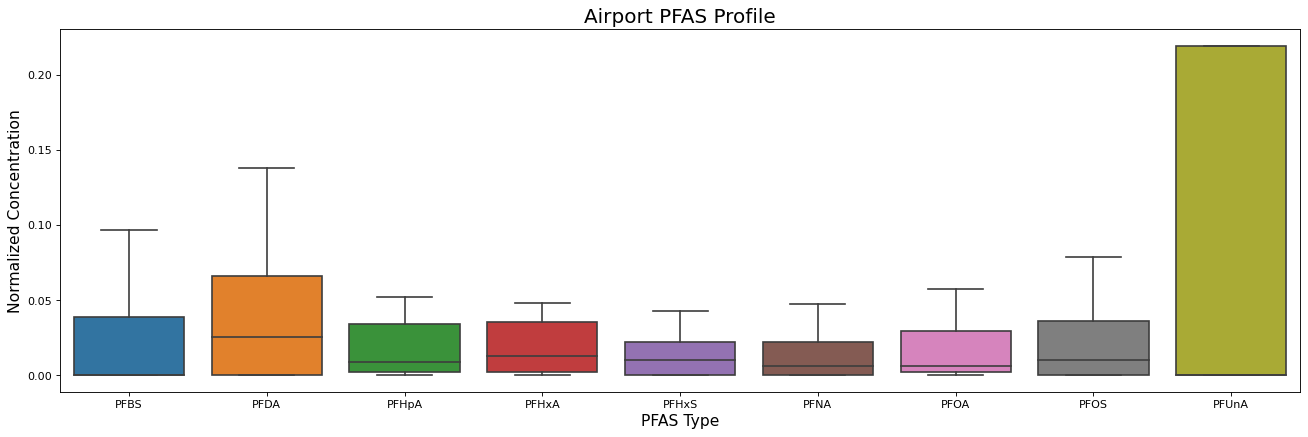

In [7]:
plt.figure(figsize=(20, 6), dpi=80)
plt.title('Airport PFAS Profile', fontsize=18)

sns.boxplot(x="variable", y="value", data=pd.melt(airport_df_eda[pfas_vars]), showfliers = False)
plt.xlabel('PFAS Type', fontsize=14)
plt.ylabel('Normalized Concentration', fontsize=14)
plt.show()

## PCA
* We should use enough eigenvectors to explain 70% (or more) of the variance, or up to 2 (or more) eigenvectors for each potential source.

In [8]:
from sklearn.decomposition import PCA

In [9]:
# Standardize data.
airport_pca = utils.normalize_over_partitions(df = airport_df, 
                                          pfas_vars = pfas_vars,
                                          units_col = 'Units',
                                          scaler_fn = 'Zscore')

In [10]:
airport_pca.head(3)

,Unnamed: 0,report,date_sampled,sample_id,lab,Matrix,Units,PFBS,PFDA,PFHpA,PFHxA,PFHxS,PFNA,PFOA,PFOS,PFUnA
0,0,3-0036118 - Beverly - Document_ID_583652 MW A.pdf,3/12/2020,20C0628-01,Con-Test,Ground Water,ng/l,0.098914,-0.307368,-0.467692,-0.493310,-0.293918,-0.32973,-0.369294,-0.355198,0.657841
1,1,3-0036118 - Beverly - Document_ID_583652 MW A.pdf,3/12/2020,20C0628-03,Con-Test,Ground Water,ng/l,1.277398,-0.307368,-0.456956,-0.487230,-0.293918,-0.32973,-0.353707,-0.355198,0.657841
2,2,3-0036118 - Beverly - Document_ID_583652 MW A.pdf,3/12/2020,20C0628-04,Con-Test,Ground Water,ng/l,0.339421,-0.307368,-0.464312,-0.489492,-0.293918,-0.32973,-0.353274,-0.355198,0.657841


In [11]:
airport_df = airport_pca.copy()

# Find 6 principal components (PCs).
pca = PCA(n_components=6)
Principal_components=pca.fit_transform(airport_df[pfas_vars])

pca_df = pd.DataFrame(data = Principal_components, columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6'])

# Compute loadings.
component_matrix = pca.components_
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

In [12]:
import pickle as pk

# Save PCA for source attribution
# pk.dump(pca, open("../results/airport_pca_pfas18.pkl", "wb"))

### Visualization

In [13]:
# Examine PCA results
PC_values = np.arange(pca.n_components_) + 1

out_sum = np.cumsum(pca.explained_variance_ratio_)

In [14]:
print ("Proportion of Variance Explained : ", pca.explained_variance_ratio_)
print ("Cumulative Prop. Variance Explained: ", out_sum)

Proportion of Variance Explained :  [0.46370939 0.26314575 0.10993457 0.06364899 0.04989382 0.04167935]
Cumulative Prop. Variance Explained:  [0.46370939 0.72685514 0.83678971 0.90043871 0.95033252 0.99201187]


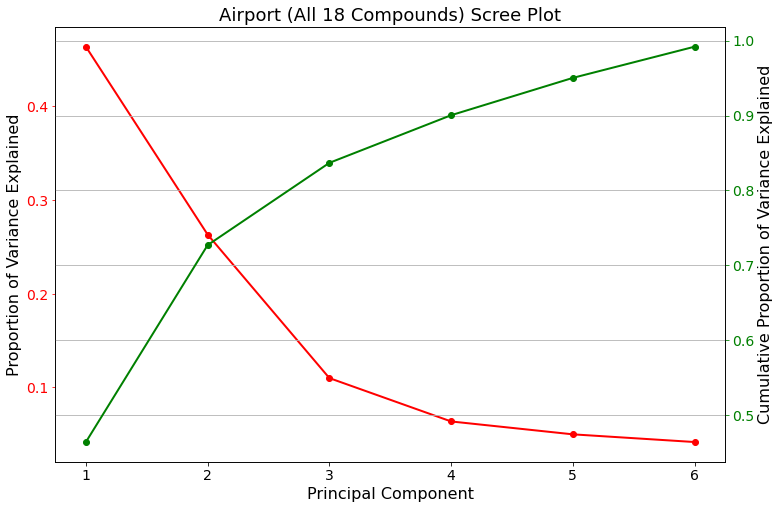

In [15]:
# Make y-y scree plot
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
ax1.set_title('Airport (All 18 Compounds) Scree Plot', fontsize=18)
ax1.set_xlabel('Principal Component', fontsize=16)
ax1.set_ylabel('Proportion of Variance Explained', fontsize=16)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', color='red', labelcolor='red', labelsize=14)

ax2 = ax1.twinx()
ax2.plot(PC_values, out_sum, 'go-', linewidth=2)
ax2.set_ylabel('Cumulative Proportion of Variance Explained', fontsize=16)
ax2.tick_params(axis='y', color='green', labelcolor='green', labelsize=14)
plt.grid()
# plt.show()
# plt.savefig('../Airport_PCA_Scree_Plot.png', transparent=True)

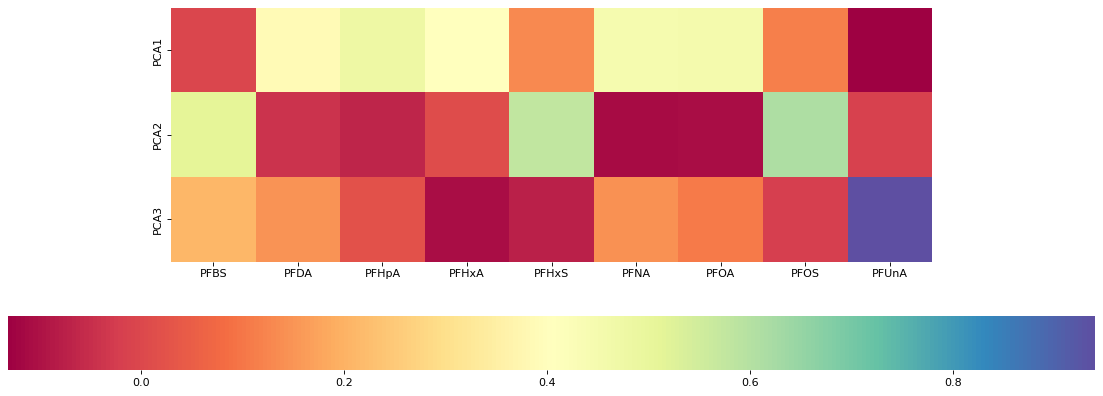

In [16]:
# Plot correlation matrix of the PCs.
plt.figure(figsize=(20, 6), dpi=80)

ax = sns.heatmap(component_matrix[:3],
                 cmap='Spectral',
                 yticklabels=[ "PCA"+str(x) for x in range(1,3+1)],
                 xticklabels=list(airport_df[pfas_vars].columns),
                 cbar_kws={"orientation": "horizontal"})

ax.set_aspect("equal")
plt.show()

In [17]:
# Get the actual values of the component matrix
### These will indicate which compounds are the most important ones to each PC
feature_imp_matrix = pd.DataFrame(component_matrix[:3], columns = airport_df[pfas_vars].columns)
feature_imp_matrix = feature_imp_matrix.T.rename(columns = {0 : 'PC1',
                                                            1 : 'PC2',
                                                            2 : 'PC3'})

In [18]:
pd.DataFrame(feature_imp_matrix.sort_values(by=['PC1'], key = abs, ascending = False))

,PC1,PC2,PC3
PFHpA,0.478997,-0.066406,0.022837
PFOA,0.454610,-0.109041,0.105021
PFNA,0.449789,-0.113566,0.142329
PFHxA,0.405344,0.008702,-0.107784
PFDA,0.387164,-0.042614,0.148161
PFHxS,0.131500,0.579270,-0.074112
PFUnA,-0.131294,-0.017188,0.940271
PFOS,0.113291,0.609953,-0.020372
PFBS,-0.004112,0.510901,0.211200


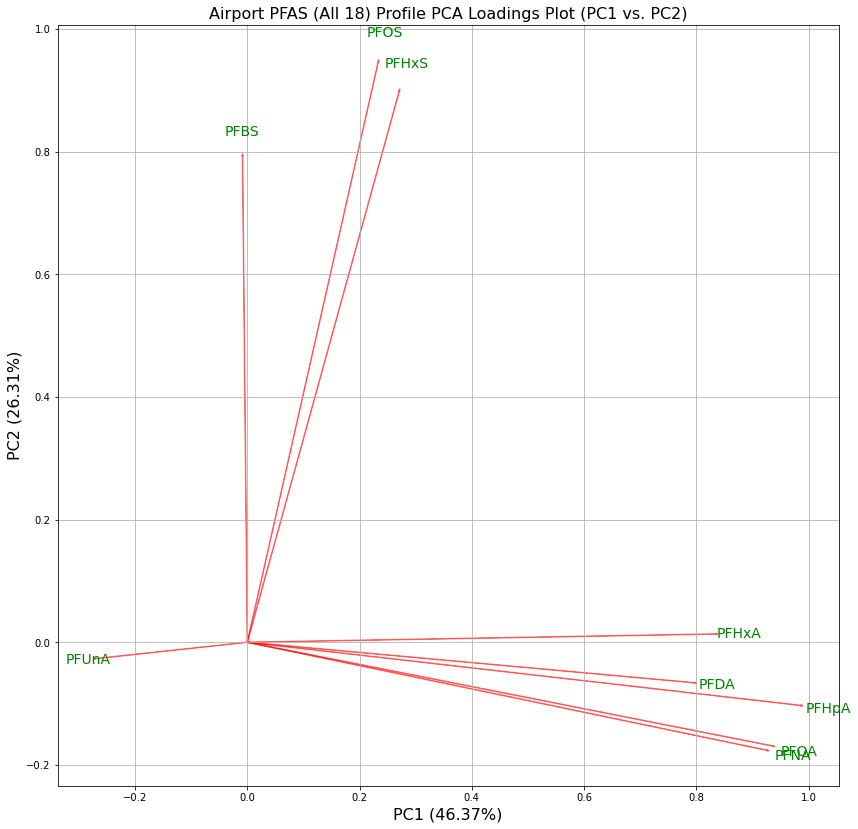

In [19]:
# Plot 2-D Loadings
fig =  plt.figure(figsize=(14, 14))
for i, varnames in enumerate(airport_df[pfas_vars].columns.values):
    plt.arrow(0, 0, loadings[i,0], loadings[i,1], color='r', alpha=0.5)
    plt.text(loadings[i,0]*1.05, loadings[i,1]*1.05, varnames, color='green', ha='center', va='center', fontsize=14)
    
plt.xlabel("PC1 ({}%)".format(round(pca.explained_variance_ratio_[0]*100, 2)), fontsize=16)
plt.ylabel("PC2 ({}%)".format(round(pca.explained_variance_ratio_[1]*100, 2)), fontsize=16)
plt.title('Airport PFAS (All 18) Profile PCA Loadings Plot (PC1 vs. PC2)', fontsize=16)
plt.grid()
plt.show()
# plt.savefig('../Airport_PC1_PC2_Loadings.png')

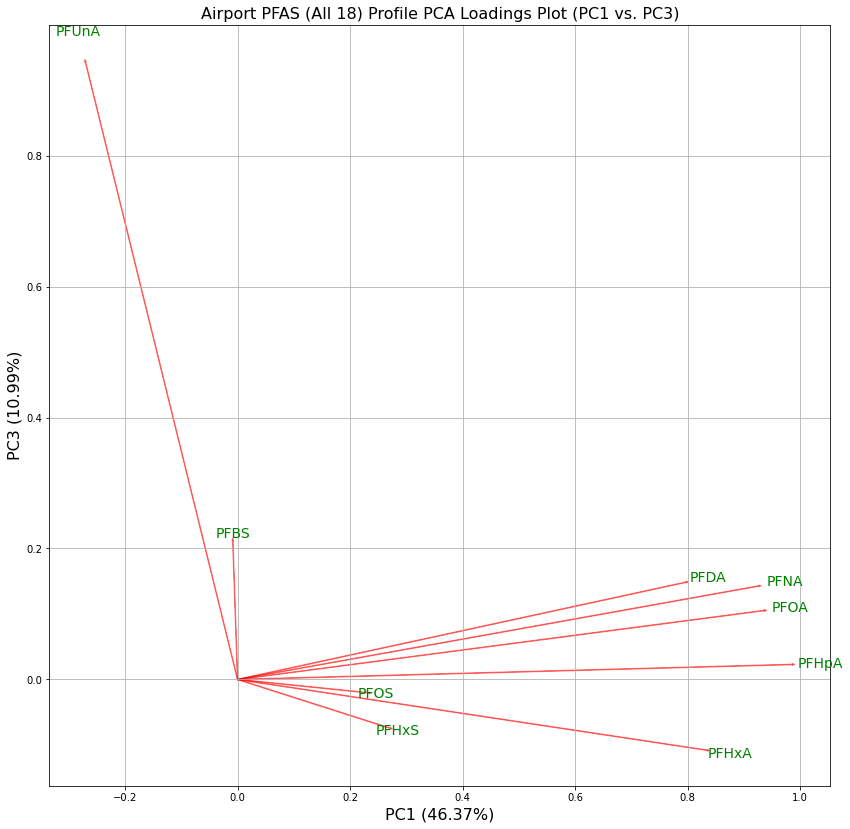

In [20]:
fig =  plt.figure(figsize=(14, 14))
for i, varnames in enumerate(airport_df[pfas_vars].columns.values):
    plt.arrow(0, 0, loadings[i,0], loadings[i,2], color='r', alpha=0.5)
    plt.text(loadings[i,0]*1.05, loadings[i,2]*1.05, varnames, color='green', ha='center', va='center', fontsize=14)
    
plt.xlabel("PC1 ({}%)".format(round(pca.explained_variance_ratio_[0]*100, 2)), fontsize=16)
plt.ylabel("PC3 ({}%)".format(round(pca.explained_variance_ratio_[2]*100, 2)), fontsize=16)
plt.title('Airport PFAS (All 18) Profile PCA Loadings Plot (PC1 vs. PC3)', fontsize=16)
plt.grid()
plt.show()
# plt.savefig('../Airport_PC1_PC3_Loadings.png')

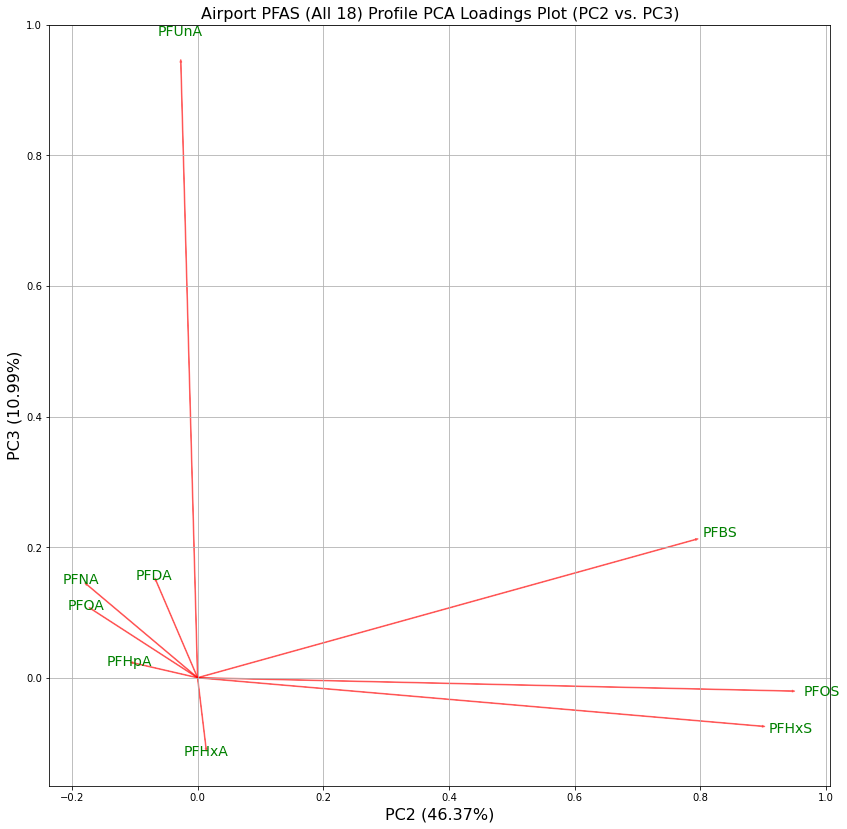

In [21]:
fig =  plt.figure(figsize=(14, 14))
for i, varnames in enumerate(airport_df[pfas_vars].columns.values):
    plt.arrow(0, 0, loadings[i,1], loadings[i,2], color='r', alpha=0.5)
    plt.text(loadings[i,1]*1.05, loadings[i,2]*1.05, varnames, color='green', ha='center', va='center', fontsize=14)
    
plt.xlabel("PC2 ({}%)".format(round(pca.explained_variance_ratio_[0]*100, 2)), fontsize=16)
plt.ylabel("PC3 ({}%)".format(round(pca.explained_variance_ratio_[2]*100, 2)), fontsize=16)
plt.title('Airport PFAS (All 18) Profile PCA Loadings Plot (PC2 vs. PC3)', fontsize=16)
plt.grid()
plt.show()
# plt.savefig('../Airport_PC2_PC3_Loadings.png')

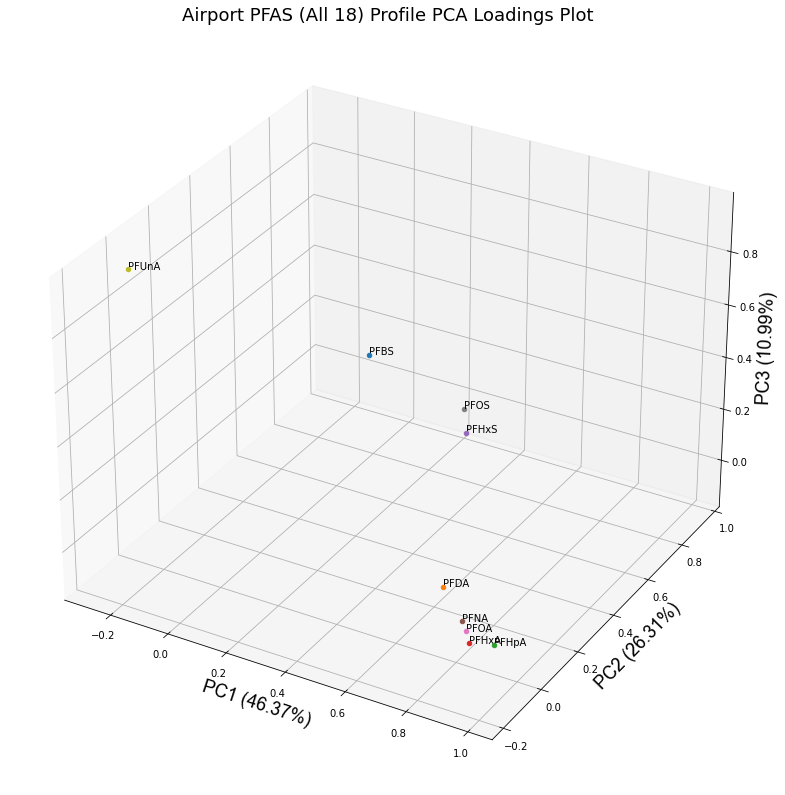

In [22]:
# 3D
utils.pcaplot(x=loadings[:,0], y=loadings[:,1], z=loadings[:,2], labels=airport_df[pfas_vars].columns.values, 
              var1=round(pca.explained_variance_ratio_[0]*100, 2),
              var2=round(pca.explained_variance_ratio_[1]*100, 2), 
              var3=round(pca.explained_variance_ratio_[2]*100, 2),
              dim=(14, 14), axlabelfontsize=18)
# plt.quiver(0, 0, 0, loadings[2, 0], loadings[2, 1], loadings[2, 2], color='r', length=1.0, alpha=0.5)
plt.title('Airport PFAS (All 18) Profile PCA Loadings Plot', fontsize=18)
plt.show()
# plt.savefig('../plots/Airport_3D_Loadings.png')

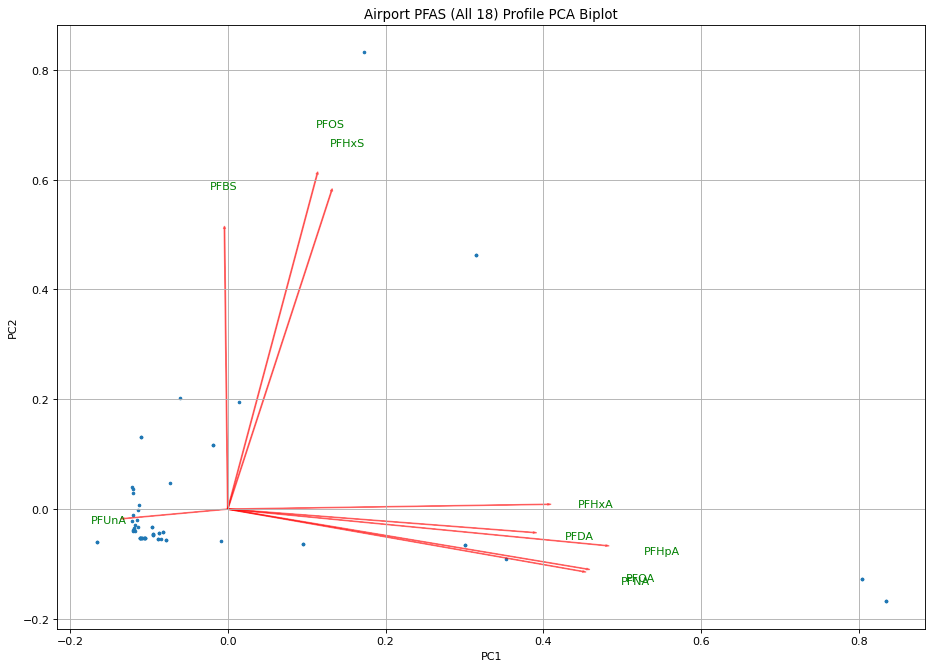

In [23]:
utils.pca_loadings_plot(Principal_components[:,0:2],np.transpose(pca.components_[0:2, :]),list(airport_df[pfas_vars].columns), title = "Airport PFAS (All 18) Profile PCA Biplot")
plt.show()

****

### Hierarchical Clustering (HC)
* HC via "Ward" method and euclidean distance.
* Ward method minimizes within-cluster variance.
* Determine the optimal # of clusters for compounds or samples using the dendrogram.
    - Look for the longest vertical line(s) that does not cross another horizontal line.

In [24]:
import scipy.cluster.hierarchy as shc

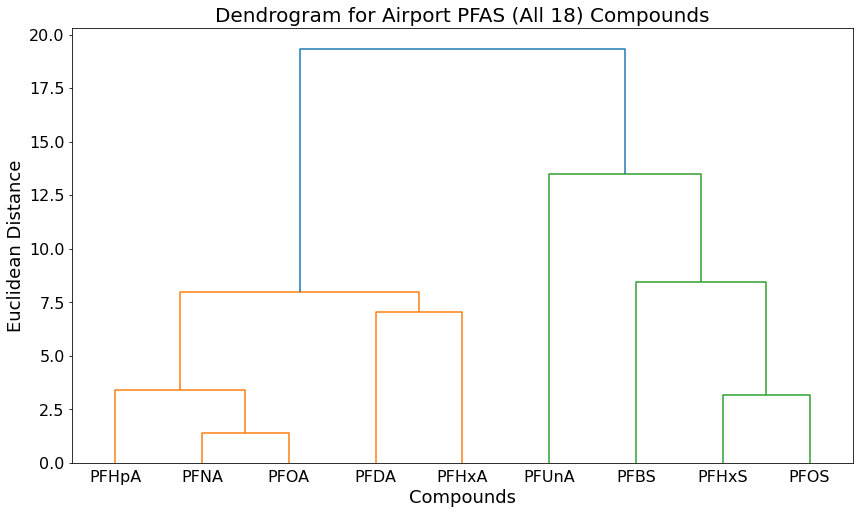

In [25]:
plt.figure(figsize=(14, 8))
dend = shc.dendrogram(shc.linkage(airport_df[pfas_vars].T, method='ward'), labels = airport_df[pfas_vars].T.index)
plt.title("Dendrogram for Airport PFAS (All 18) Compounds", fontsize=20)
plt.xlabel("Compounds", fontsize=18)
plt.ylabel("Euclidean Distance", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

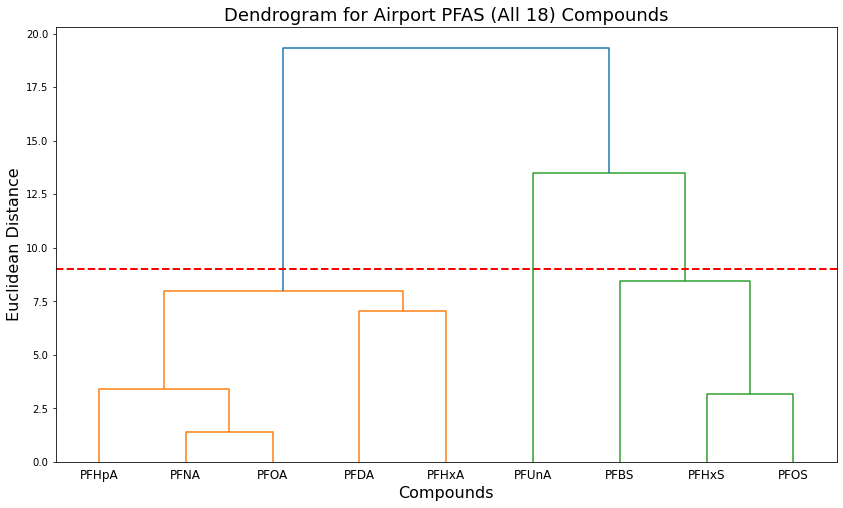

In [26]:
plt.figure(figsize=(14, 8))
dend = shc.dendrogram(shc.linkage(airport_df[pfas_vars].T, method='ward'), labels = airport_df[pfas_vars].T.index)
plt.title("Dendrogram for Airport PFAS (All 18) Compounds", fontsize=18)
plt.xlabel("Compounds", fontsize=16)
plt.ylabel("Euclidean Distance", fontsize=16)
plt.axhline(y=9., color='r', linestyle='--', linewidth=2)
# Other lines, but might be overkill.
# plt.axhline(y=7.5, color='r', linestyle='--')
plt.show()
# plt.savefig('./Airport_HC_Dendrogram_CO9.png')

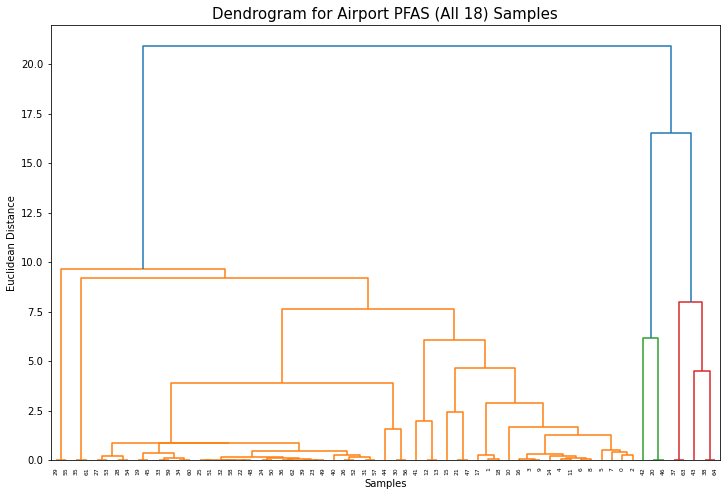

In [27]:
# Dendrogram for samples.
plt.figure(figsize=(12, 8))
dend = shc.dendrogram(shc.linkage(airport_df[pfas_vars], method='ward'))
plt.title("Dendrogram for Airport PFAS (All 18) Samples", fontsize=15)
plt.xlabel("Samples")
plt.ylabel("Euclidean Distance")
plt.show()

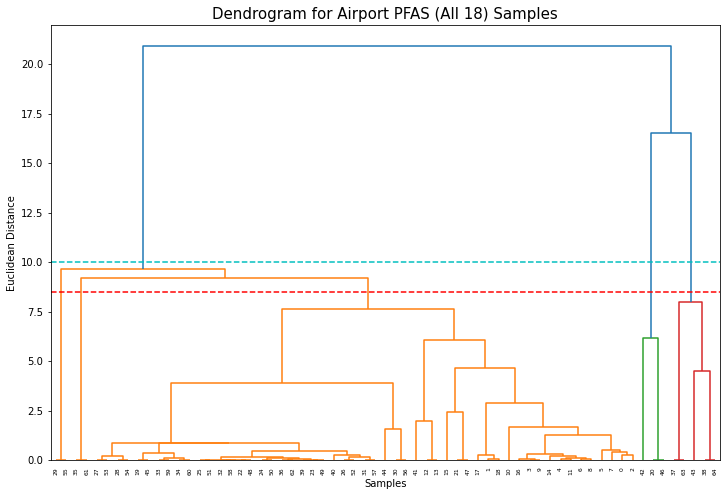

In [28]:
plt.figure(figsize=(12, 8))
dend = shc.dendrogram(shc.linkage(airport_df[pfas_vars], method='ward'))
plt.title("Dendrogram for Airport PFAS (All 18) Samples", fontsize=15)
plt.xlabel("Samples")
plt.ylabel("Euclidean Distance")
plt.axhline(y=10.0, color='c', linestyle='--')
# Other lines, but might be overkill.
plt.axhline(y=8.5, color='r', linestyle='--')
# plt.axhline(y=2.75, color='g', linestyle='--')
plt.show()

In [29]:
# Predict clusters using agglomerative clustering
from sklearn.cluster import AgglomerativeClustering

# Based on analysis of dendrogram above, we will select # of clusters.
numClusters = 3
clusterHC = AgglomerativeClustering(n_clusters=numClusters, affinity='euclidean', linkage='ward')  
y_hc = clusterHC.fit_predict(airport_df[pfas_vars])

In [30]:
# Visualize clusters in 2D scatter plot. Can only pick up to three compounds at a time,
# but will only plot the first two on the list for 2D scatter plot.
# test = cluster.labels_
y_hc_loc0 = airport_df.iloc[y_hc==0]
y_hc_loc1 = airport_df.iloc[y_hc==1]
y_hc_loc2 = airport_df.iloc[y_hc==2]

pfas_col_num = [1, 4, 5]
pfas_col_names = [pfas_vars[i] for i in pfas_col_num]
# print(pfas_names)

data0 = y_hc_loc0[pfas_col_names]
data1 = y_hc_loc1[pfas_col_names]
data2 = y_hc_loc2[pfas_col_names]
# print(data0)

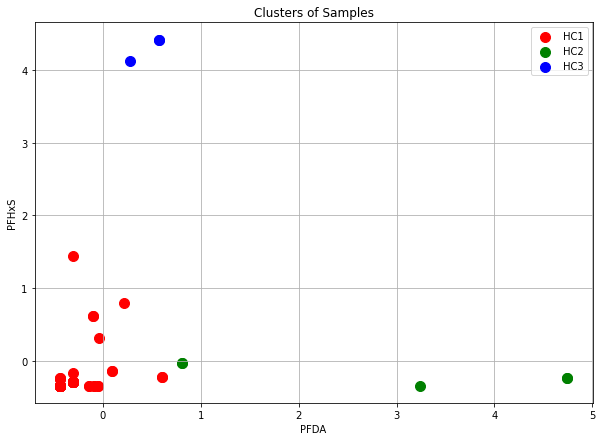

In [31]:
# Plot clusters in 2D
plt.figure(figsize=(10, 7))

# plt.scatter(data0, data1, data2, c=clusterHC.labels_)
plt.scatter(data0.iloc[:, 0], data0.iloc[:, 1], s=100, c='red', label='HC1')
plt.scatter(data1.iloc[:, 0], data1.iloc[:, 1], s=100, c='green', label='HC2')
plt.scatter(data2.iloc[:, 0], data2.iloc[:, 1], s=100, c='blue', label='HC3')

plt.title("Clusters of Samples")
plt.xlabel(pfas_col_names[0])
plt.ylabel(pfas_col_names[1])
plt.legend()
plt.grid(True)

plt.show()

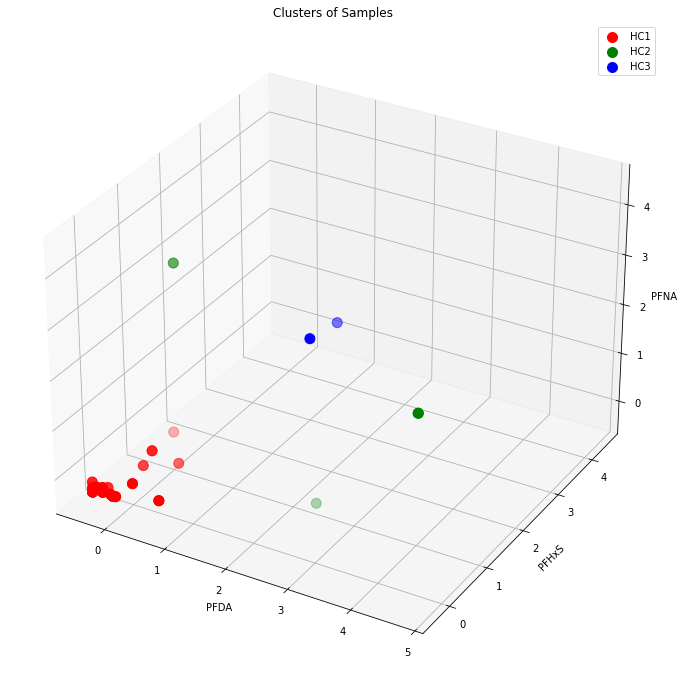

In [32]:
# Plot clusters in 3D
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(16, 12))
ax = plt.axes(projection ="3d")

# plt.scatter(data0, data1, data2, c=clusterHC.labels_)
ax.scatter3D(data0.iloc[:, 0], data0.iloc[:, 1], data0.iloc[:, 2], s=100, c='red', label='HC1')
ax.scatter3D(data1.iloc[:, 0], data1.iloc[:, 1], data1.iloc[:, 2], s=100, c='green', label='HC2')
ax.scatter3D(data2.iloc[:, 0], data2.iloc[:, 1], data2.iloc[:, 2], s=100, c='blue', label='HC3')

plt.title("Clusters of Samples")
plt.legend()
ax.set_xlabel(pfas_col_names[0])
ax.set_ylabel(pfas_col_names[1])
ax.set_zlabel(pfas_col_names[2])

plt.show()

In [33]:
# Set up box and whisker plots for each cluster for visualizing the profiles.
pfas_col_num = np.arange(len(pfas_vars))
pfas_col_names = [pfas_vars[i] for i in pfas_col_num]

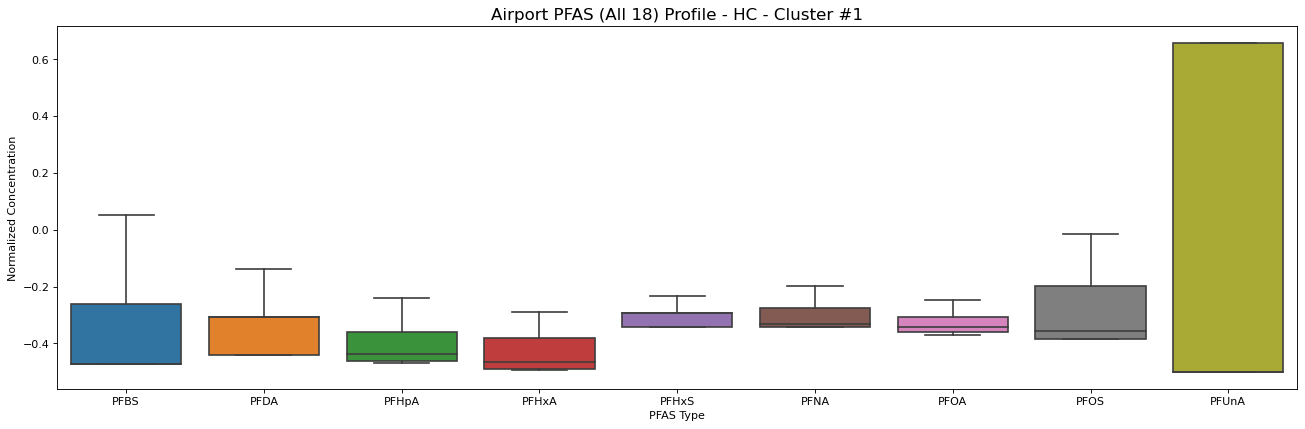

In [34]:
plt.figure(figsize=(20, 6), dpi=80)
plt.title('Airport PFAS (All 18) Profile - HC - Cluster #1', fontsize=15)

sns.boxplot(x="variable", y="value", data=pd.melt(y_hc_loc0[pfas_col_names]), showfliers = False)
plt.xlabel('PFAS Type')
plt.ylabel('Normalized Concentration')
# Set all clusters to have the same y-axis scaling (for better comparison)
# plt.ylim(0, 1.05)
plt.show()

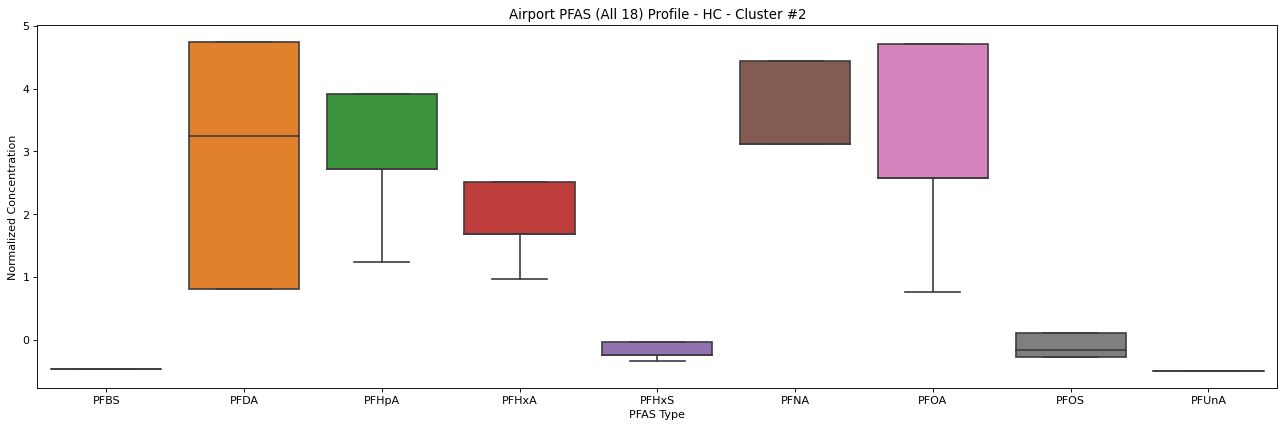

In [35]:
plt.figure(figsize=(20, 6), dpi=80)
plt.title('Airport PFAS (All 18) Profile - HC - Cluster #2')

sns.boxplot(x="variable", y="value", data=pd.melt(y_hc_loc1[pfas_col_names]), showfliers = False)
plt.xlabel('PFAS Type')
plt.ylabel('Normalized Concentration')
plt.show()

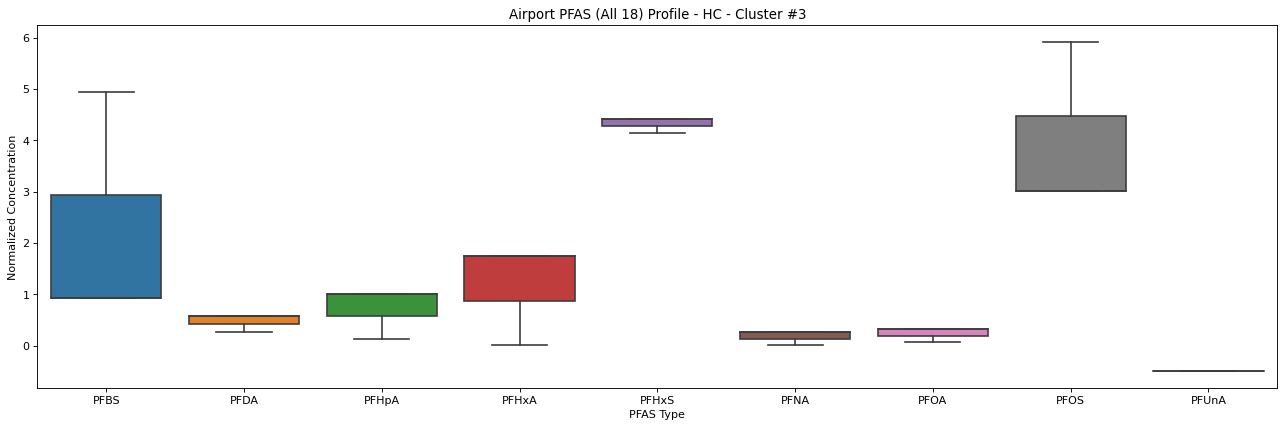

In [36]:
if numClusters > 2:
    plt.figure(figsize=(20, 6), dpi=80)
    plt.title('Airport PFAS (All 18) Profile - HC - Cluster #3')
    
    sns.boxplot(x="variable", y="value", data=pd.melt(y_hc_loc2[pfas_col_names]), showfliers = False)
    plt.xlabel('PFAS Type')
    plt.ylabel('Normalized Concentration')
    plt.show()

****

### Spatial Inference of Hierarchical Cluster
* Create layer of locations by cluster

In [37]:
source_locations = pd.read_parquet('../../../data/disposal_sites/PFAS_Sites_2021-11-07_geocoded.parquet')

In [38]:
# print(source_locations)

In [39]:
airport_df['hclusters'] = y_hc

In [40]:
airport_df['RTN'] = utils.extract_rtn(df = airport_df,
                                    report_col = 'report')

In [41]:
airport_df = airport_df.merge(source_locations[['RTN', 'lat', 'lon']], on = 'RTN')
# airport_df.head(5)

In [42]:
airport_df = utils.add_wiggliness_for_spatial_interpolation(df = airport_df,
                                                          lat_col = 'lat',
                                                          lon_col = 'lon')

In [43]:
airport_gdf = gpd.GeoDataFrame(
    airport_df, 
    geometry=gpd.points_from_xy(airport_df.lon, airport_df.lat),
    crs={"init":"EPSG:4326"})

/anaconda3/envs/py38-gis/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [44]:
airport_df.to_file('../../../data/modeling_data/source_attribution/profiling/airport_clusters.geojson', driver = 'GeoJSON')